패키지 참조 -> 데이터 셋 준비 -> 데이터 전처리 -> 탐색적 데이터 분석 -> 데이터 셋 분할 -> 모델 개발 -> 학습 결과 평가 -> 학습 결과 적용

![분석순서](https://velog.velcdn.com/images/jaekim3220/post/1d6d9d2e-a257-444d-8a7c-6a35e76ca843/image.png)

# 연습문제 3 와인 종류 분류

## #01. 패키지 및 그래프

In [1]:
import sys
sys.path.append("../../../")
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터 준비

In [3]:
origin = read_excel("https://data.hossam.kr/F03/wine_3type.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    int64  
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    int64  
 13  kind 

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,kind
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,class_0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,class_0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,class_0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,class_0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,class_0


## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
kind                            0
dtype: int64

### 명목형 변수 형변환

***명목형 처리(더미변수/카테고리화)***

- `더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

>명목형 확인을 위해서는 데이터의 종류가 몇 가지인지 확인.
즉, 명목형으로 의심되면 일단 value_counts()로 확인.
type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능.

>sigmoid는 이항분류, softmax는 다항분류(one-hot-encoding-즉, 더미변수화)

***종속변수 카테고리의 기준***

>탐색적 데이터 분석에서 사용하기 위해 카테고리화를 진행 - (단, 통계에서는 카테고리 형식으로 데이터를 분석하지 않고 int 형식으로 사용)

>정석대로라면 카테고리로 변경하지 않음. 
단, 탐색적 데이터 분석을 한다면 명목형 변수를 제거해야 하는데 명목형을 카테고리로 변경하면 자동으로 제거해주기 때문에 카테고리 형식으로 변환 후 진행. 

>category 대신 더미변수로 변경하면 int로 돌아오므로 더미변수화를 추천.

In [5]:
origin['kind'] = origin['kind'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   alcohol                       178 non-null    float64 
 1   malic_acid                    178 non-null    float64 
 2   ash                           178 non-null    float64 
 3   alcalinity_of_ash             178 non-null    float64 
 4   magnesium                     178 non-null    int64   
 5   total_phenols                 178 non-null    float64 
 6   flavanoids                    178 non-null    float64 
 7   nonflavanoid_phenols          178 non-null    float64 
 8   proanthocyanins               178 non-null    float64 
 9   color_intensity               178 non-null    float64 
 10  hue                           178 non-null    float64 
 11  od280/od315_of_diluted_wines  178 non-null    float64 
 12  proline                       178 non-null    int6

### #04. 탐색적 데이터 분석

### 기본(기초)통계 확인

In [6]:
origin.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### boxplot

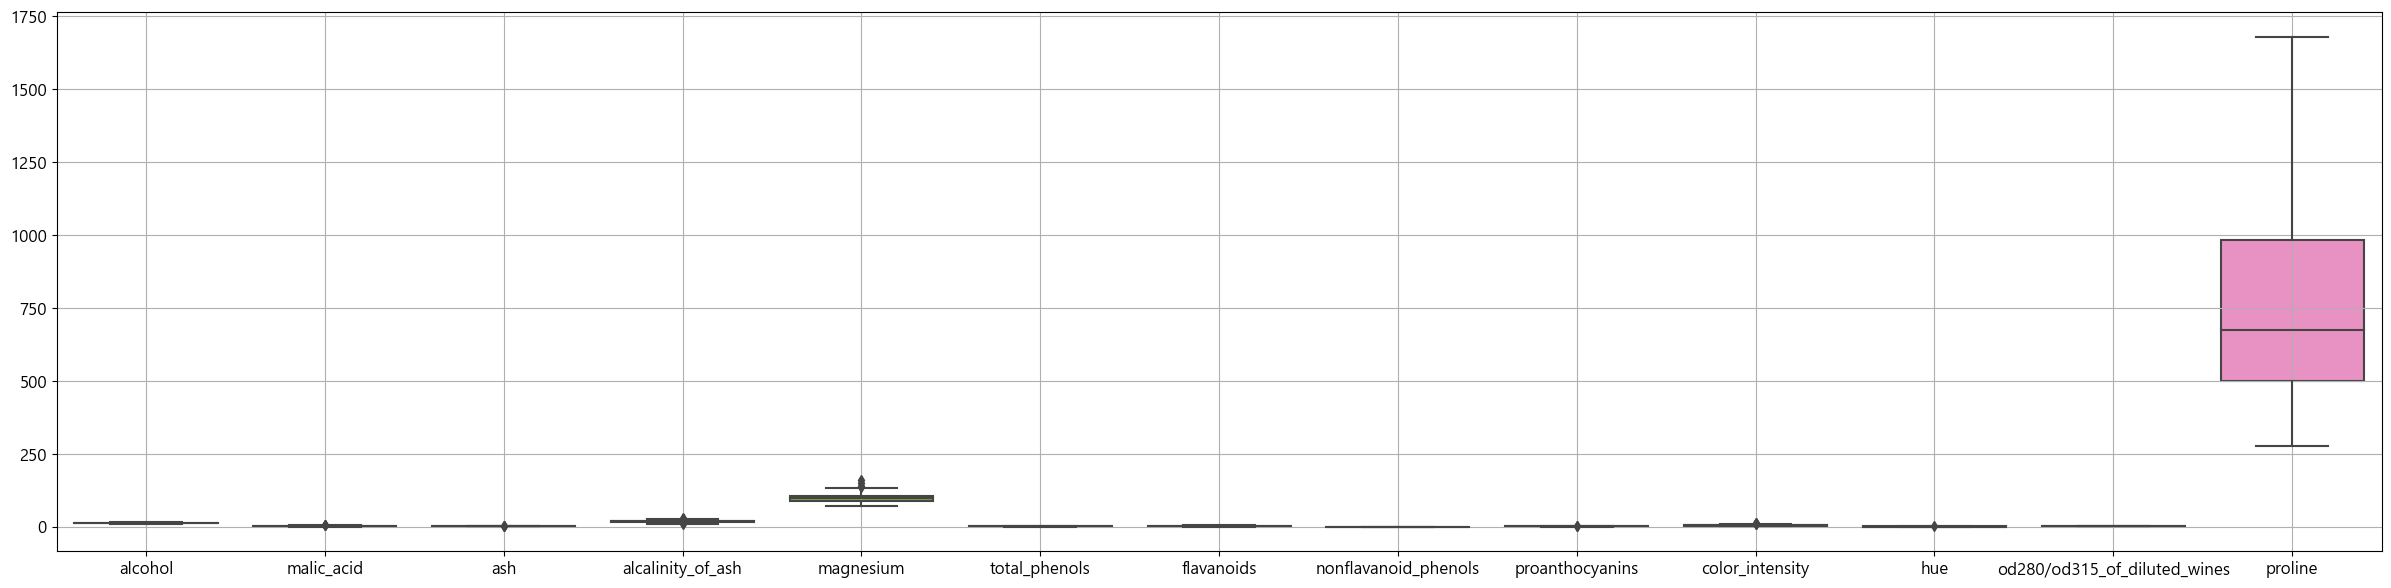

In [7]:
plt.figure(figsize=(30,7))
sb.boxplot(data=origin)
plt.grid()
plt.show()
plt.close()

> 데이터 분포가 서로 상이하므로 표준화 진행

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [8]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
origin.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'kind'],
      dtype='object')

In [10]:
x = origin.drop('kind', axis=1)
y = origin[['kind']]
print(x.shape, y.shape)
y

(178, 13) (178, 1)


,kind
0,class_0
1,class_0
2,class_0
3,class_0
4,class_0
...,...
173,class_2
174,class_2
175,class_2
176,class_2


In [11]:
print(type(y), type(x))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


### `종속변수에 대한 one-hot-encoding`

***명목형 처리(더미변수/카테고리화)***

- `더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

>명목형 확인을 위해서는 데이터의 종류가 몇 가지인지 확인.
즉, 명목형으로 의심되면 일단 value_counts()로 확인.
type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능.

>sigmoid는 이항분류, softmax는 다항분류(one-hot-encoding-즉, 더미변수화)

***종속변수 카테고리의 기준***

>탐색적 데이터 분석에서 사용하기 위해 카테고리화를 진행 - (단, 통계에서는 카테고리 형식으로 데이터를 분석하지 않고 int 형식으로 사용)

>정석대로라면 카테고리로 변경하지 않음. 
단, 탐색적 데이터 분석을 한다면 명목형 변수를 제거해야 하는데 명목형을 카테고리로 변경하면 자동으로 제거해주기 때문에 카테고리 형식으로 변환 후 진행. 

>category 대신 더미변수로 변경하면 int로 돌아오므로 더미변수화를 추천.

In [12]:
y.value_counts()

kind   
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64

In [13]:
y['kind'] = y['kind'].map({'class_0': 0, 'class_1': 1, 'class_2': 2})
y

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10488\653532542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['kind'] = y['kind'].map({'class_0': 0, 'class_1': 1, 'class_2': 2})


,kind
0,0
1,0
2,0
3,0
4,0
...,...
173,2
174,2
175,2
176,2


In [14]:
y_cate = to_categorical(y)
y_cate

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

### 데이터 표준화

데이터 타입을 numpy, Seris, category, DataFrame으로 할지 명확하게 선정.

In [15]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
x_scale_df = DataFrame(x_scale, columns=x.columns, index=x.index)
x_scale_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


### 훈련 데이터와 검증 데이터로 분할

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_scale_df, y_cate, test_size=0.3, random_state=777)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train

(124, 13) (54, 13) (124, 3) (54, 3)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
124,-1.396613,1.771674,0.085839,0.451946,-1.245695,0.905137,1.004700,-1.223610,2.311176,-0.976782,-0.910151,1.452436,-1.168369
136,-0.927212,2.139716,0.634140,0.451946,-0.754202,-1.466313,-1.565455,1.354888,-1.385721,-0.522583,-0.910151,-1.895054,-0.085641
162,-0.186053,0.838105,0.780354,0.752231,0.439425,-1.033684,-1.434939,1.918935,-1.105388,0.225763,-0.383670,-0.708602,-0.563315
27,0.369816,-0.553273,-0.827996,-0.749194,-0.403135,0.168065,0.161368,-0.740141,-0.422075,-0.479326,0.274431,0.223610,1.713598
35,0.592164,-0.472483,0.158946,0.301803,0.018145,0.648764,0.954502,-0.820719,0.471488,0.018129,0.362177,1.212320,0.551257
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,-1.668371,-0.598156,0.926567,1.953371,-0.824415,-0.601054,-0.420933,0.307374,-0.439596,-1.063296,1.766126,0.845085,-0.588791
166,0.555106,1.224100,0.853460,1.052516,0.790492,-0.953567,-1.113670,0.549108,-0.229346,2.431870,-0.471417,-1.485445,-0.165254
59,-0.778980,-1.253450,-3.679162,-2.671018,-0.824415,-0.504914,-1.465058,-0.659563,-2.051513,-1.344466,0.406051,-1.118210,-0.722540
47,1.110975,-0.589180,-0.901103,-1.049479,0.088358,1.289697,1.366128,-1.223610,0.962071,0.450699,-0.208177,1.014578,0.758249


## #06. 모델 개발

### 모델 정의

>모델 정의를 재시작하면 학습한 모델이 포맷.

>sigmoid는 이항분류, softmax는 다항분류(원핫인코딩-즉, 더미변수화)

> relu, sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense(출력 수) 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [17]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(x_train.columns), )))
model.add(Dense(3, activation='softmax'))   #종속변수 kind의 값이 3개라서 Dense 값이 3
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1091 (4.26 KB)
Trainable params: 1091 (4.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

> 모델 정의를 재시작하지 않고 학습을 진행하면 모델의 성능이 중첩되어 더 좋아짐.

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [18]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 1s 102ms/step - loss: 1.3543 - acc: 0.1290 - val_loss: 1.2716 - val_acc: 0.2222 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 1.2163 - acc: 0.2177 - val_loss: 1.1489 - val_acc: 0.2963 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 1.0883 - acc: 0.3710 - val_loss: 1.0374 - val_acc: 0.5000 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 0.9730 - acc: 0.5081 - val_loss: 0.9386 - val_acc: 0.6111 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 0.8726 - acc: 0.6371 - val_loss: 0.8487 - val_acc: 0.6852 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7797 - acc: 0.7661 - val_loss: 0.7696 - val_acc: 0.8148 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 0.6993 - acc: 0.8548 - val_loss: 0.6992 - val_acc: 0.8704 - lr: 0.001

## #07. 학습 결과 평가

F./03./08(데이터프레임화, 손실률 시각화) 참고

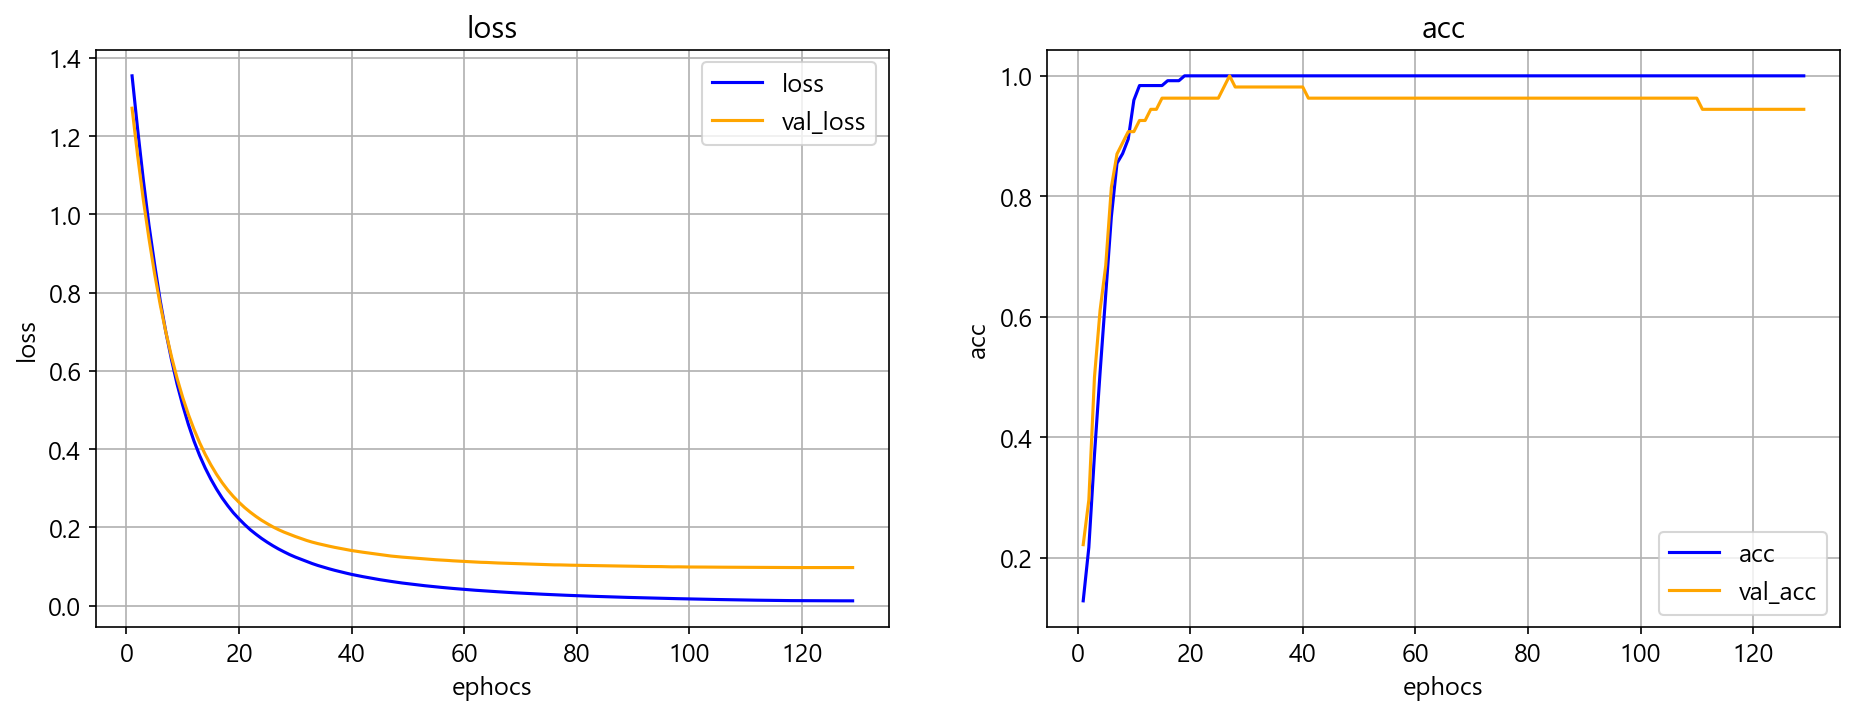

4/4 [==============================] - 0s 5ms/step - loss: 0.0124 - acc: 1.0000
최종 훈련 손실률: 0.012368, 최종 훈련 정확도: 1.000000
2/2 [==============================] - 0s 3ms/step - loss: 0.0974 - acc: 0.9444
최종 검증 손실률: 0.097411, 최종 검증 정확도: 0.944444


In [19]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))